# Fitting a line to data

The [_Getting started_ tutorial](./getting-started.ipynb) shows how to sample a 3D gaussian with `simple`.
In this tutorial, we will build on this to demonstrate a more realistic scenario where we fit a line to data.

## Simulated data

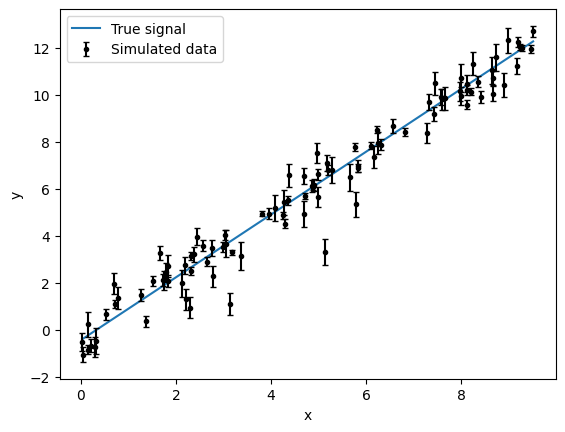

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import loguniform

rng = np.random.default_rng(123)

x = np.sort(10 * rng.random(100))
m_true = 1.338
b_true = -0.45
truths = {"m": m_true, "b": b_true, "sigma": None}
y_true = m_true * x + b_true
yerr = 0.1 + 0.5 * rng.random(x.size)
y = y_true + 2 * yerr * rng.normal(size=x.size)

ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Linear model

In the [_Getting started_](./getting-started.ipynb) tutorial, we did not have a forward model: the likelihood was directly specified as a distribution.
In most physical scenarios, we have some sort of forward model, which is then called by our likelihood.
It is also quite common that the data points are assumed to be independent, and that the likelihood is assumed to be Gaussian.
`simple` covers the forward model, and the forward model + independent Gaussian likelihood cases with the `ForwardModel` and `GaussianForwardModel` classes.
See the [tutorial on types of models](./types_of_model.ipynb) for more on this.
Here, we will use the `GaussianForwardModel` as this is simpler in practice.
Since the likelihood is already implemented by `simple`, we only need to specify our forward model.

The forward model function should accept a dictionary of parameters.

In [2]:
def forward_model(parameters, x):
    m, b = parameters["m"], parameters["b"]
    return m * x + b

We can then pass this forward model to `simple.GaussianForwardModel`.
The gaussian forward model expects a `sigma` argument, which will be added in quadrature to the error bars.

In [3]:
from scipy.stats import uniform

from simple.distributions import ScipyDistribution
from simple.model import GaussianForwardModel

parameters = {
    "m": ScipyDistribution(uniform(-10, 20)),
    "b": ScipyDistribution(uniform(-10, 20)),
    "sigma": ScipyDistribution(loguniform(1e-5, 100)),
}

model = GaussianForwardModel(parameters, forward_model)

And we can check that the model works as expected.

In [4]:
test_point = {"m": 1.0, "b": 0, "sigma": 1.0}
print("Log prior", model.log_prior(test_point))
print("Log likelihood", model.log_likelihood(test_point, x, y, yerr))
print("Log probability", model.log_prob(test_point, x, y, yerr))

Log prior -8.77140714141125
Log likelihood -212.35014668988225
Log probability -221.1215538312935


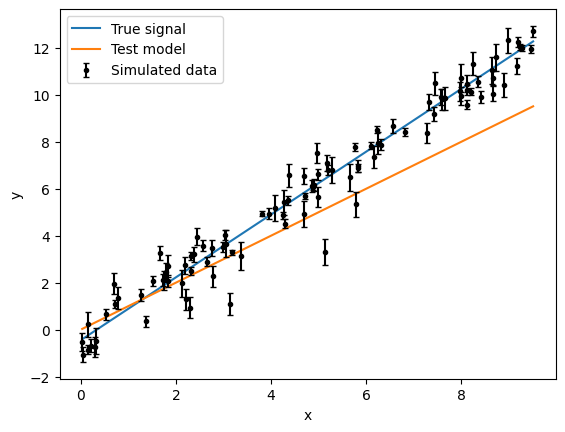

In [5]:
ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.plot(x, model.forward(test_point, x), label="Test model")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Prior checks

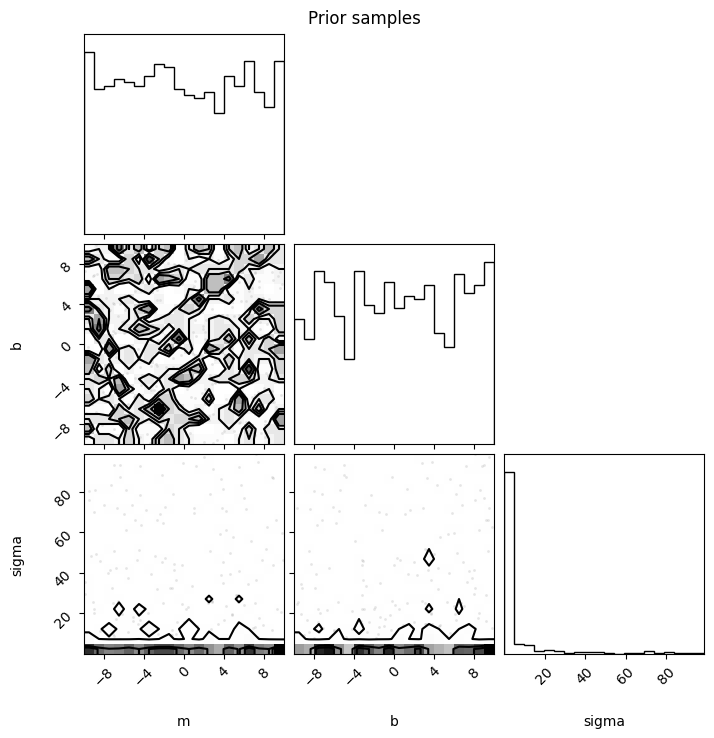

In [6]:
import corner

n_prior = 1000
prior_samples = model.get_prior_samples(n_prior)

fig = corner.corner(prior_samples)
fig.suptitle("Prior samples")
plt.show()

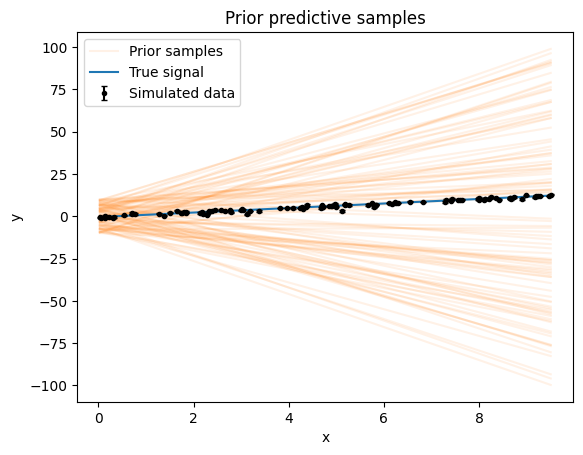

In [7]:
n_pred = 100
ypreds = model.get_prior_pred(n_pred, x)
ax = plt.gca()
for i, ypred in enumerate(ypreds):
    ax.plot(x, ypred, "C1-", label="Prior samples" if i == 0 else None, alpha=0.1)
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Prior predictive samples")
plt.legend()
plt.show()

## Sampling

In [8]:
import zeus

nwalkers = 100
nsteps = 1000
ndim = len(model.keys())
start = np.array([0.0, 0.0, 10.0]) + rng.standard_normal(size=(nwalkers, ndim))
sampler = zeus.EnsembleSampler(nwalkers, ndim, model.log_prob, args=(x, y, yerr))
sampler.run_mcmc(start, nsteps)

Initialising ensemble of 100 walkers...
Sampling progress : 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.68it/s]


## Posterior distribution and predictions

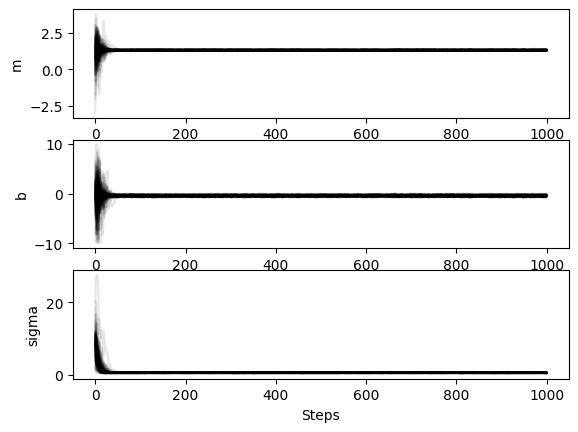

In [9]:
from simple.plot import chainplot

chains = sampler.get_chain()
chainplot(chains, labels=model.keys())
plt.show()

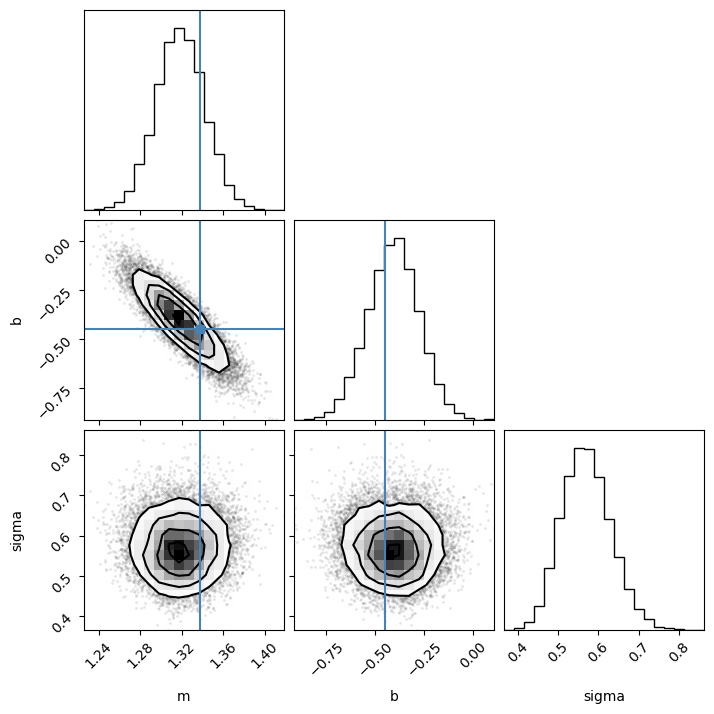

In [10]:
flat_chains = sampler.get_chain(discard=200, flat=True, thin=5)
corner.corner(
    flat_chains,
    labels=model.keys(),
    truths=list(truths.values()),
)
plt.show()

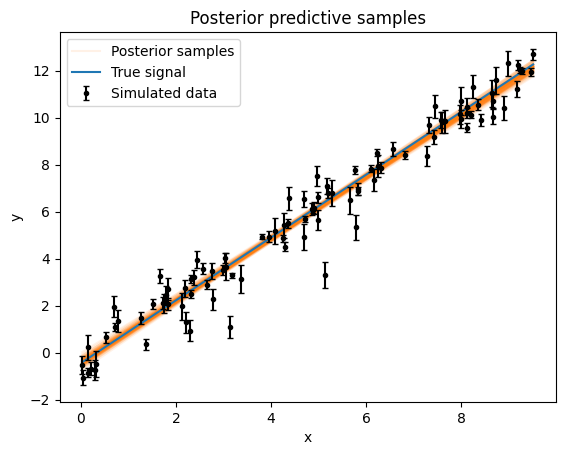

In [11]:
n_pred = 100
rng = np.random.default_rng()
show_idx = rng.choice(flat_chains.shape[0], n_pred, replace=False)
ax = plt.gca()
for i in show_idx:
    ypred = forward_model(dict(zip(model.keys(), flat_chains[i], strict=True)), x)
    ax.plot(
        x,
        ypred,
        "C1-",
        label="Posterior samples" if i == show_idx[0] else None,
        alpha=0.1,
    )
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Posterior predictive samples")
plt.legend()
plt.show()